Problem Statement

This case requires to develop a customer segmentation to define marketing strategy. The
sample Dataset summarizes the usage behavior of about 9000 active credit card holders during the last 6 months. The file is at a customer level with 18 behavioral variables.

In [1]:
from kneed import KneeLocator
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as shc
from sklearn.decomposition import PCA
import numpy as np, pandas as pd, warnings
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import DBSCAN, AgglomerativeClustering

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('C:\\Users\\Anyone\\Desktop\\cCard\\creditcard.csv')

In [3]:
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [4]:
df.duplicated().sum()

0

In [5]:
df.isnull().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [6]:
# Removing the id column, filling missing values with the mean of the column and scaling the data.

df.drop('CUST_ID',axis=1,inplace=True)
df['MINIMUM_PAYMENTS'] = df['MINIMUM_PAYMENTS'].fillna(np.mean(df['MINIMUM_PAYMENTS']))
df["CREDIT_LIMIT"] = df["CREDIT_LIMIT"].fillna(np.mean(df["CREDIT_LIMIT"]))
df_scaled = pd.DataFrame(StandardScaler().fit_transform(df))

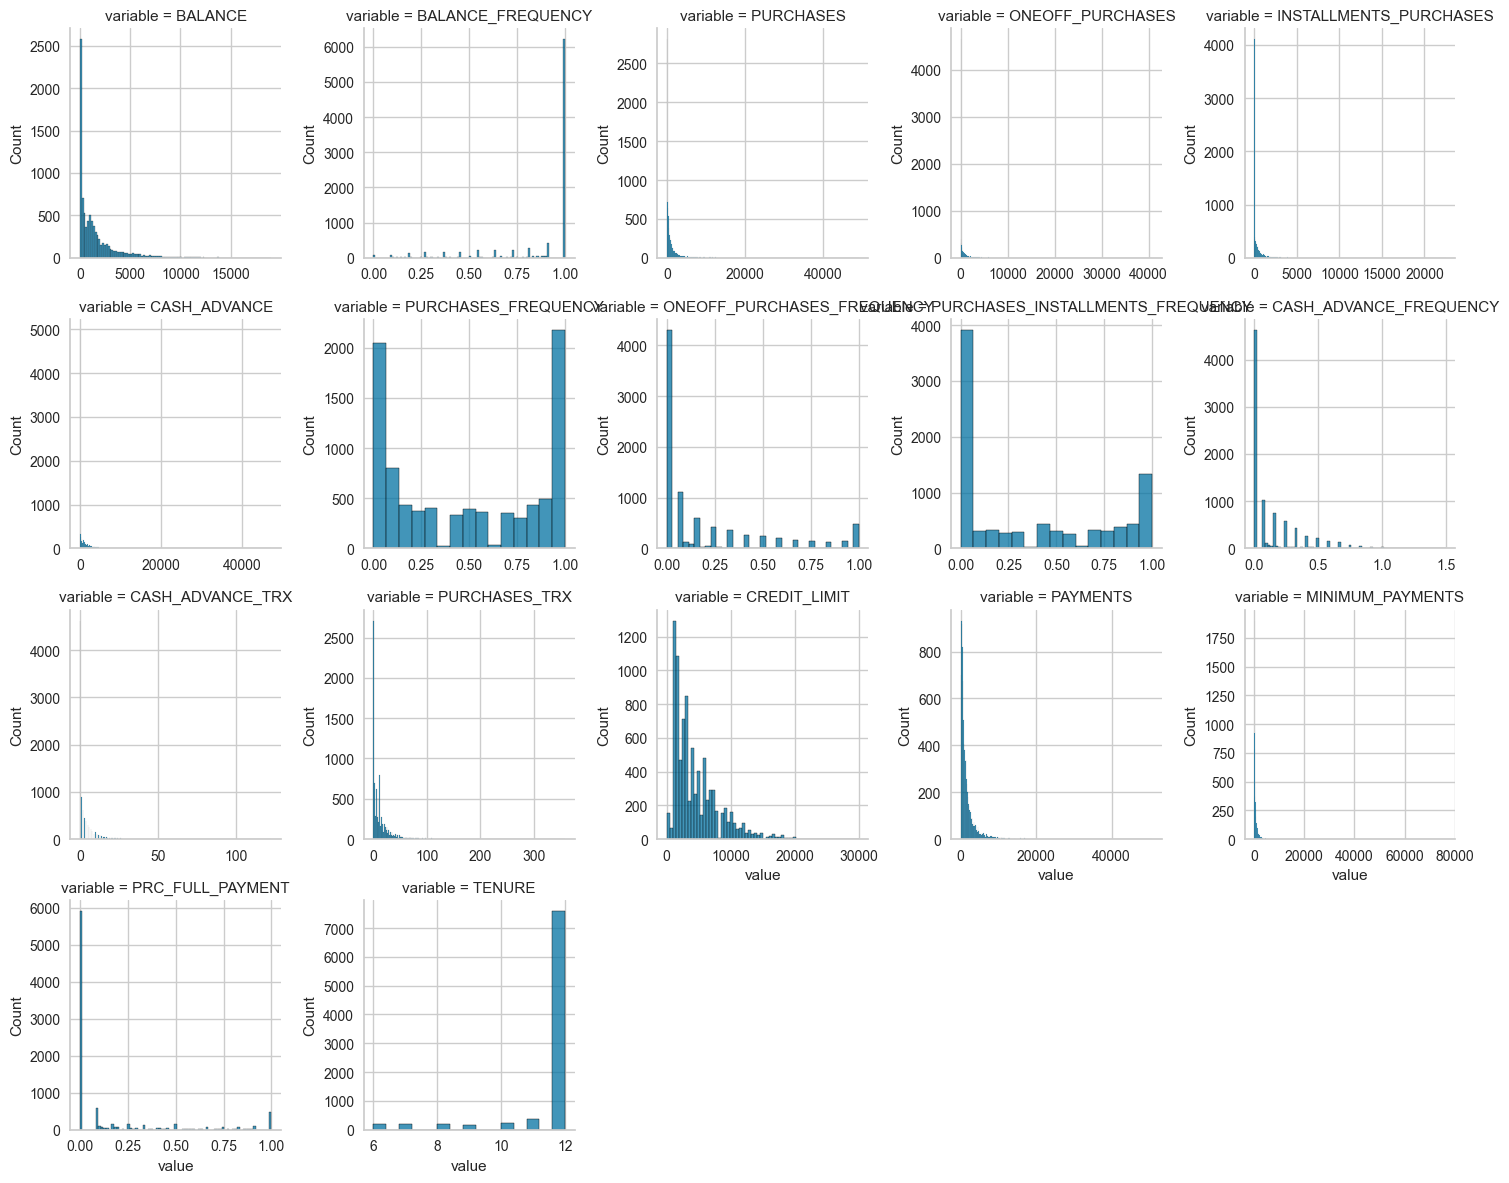

In [7]:
# Almost all the features are skewed to the right.

sns.FacetGrid(df.melt(),col='variable',col_wrap=5,sharex=False,sharey=False).map(sns.histplot, 'value')

<Axes: >

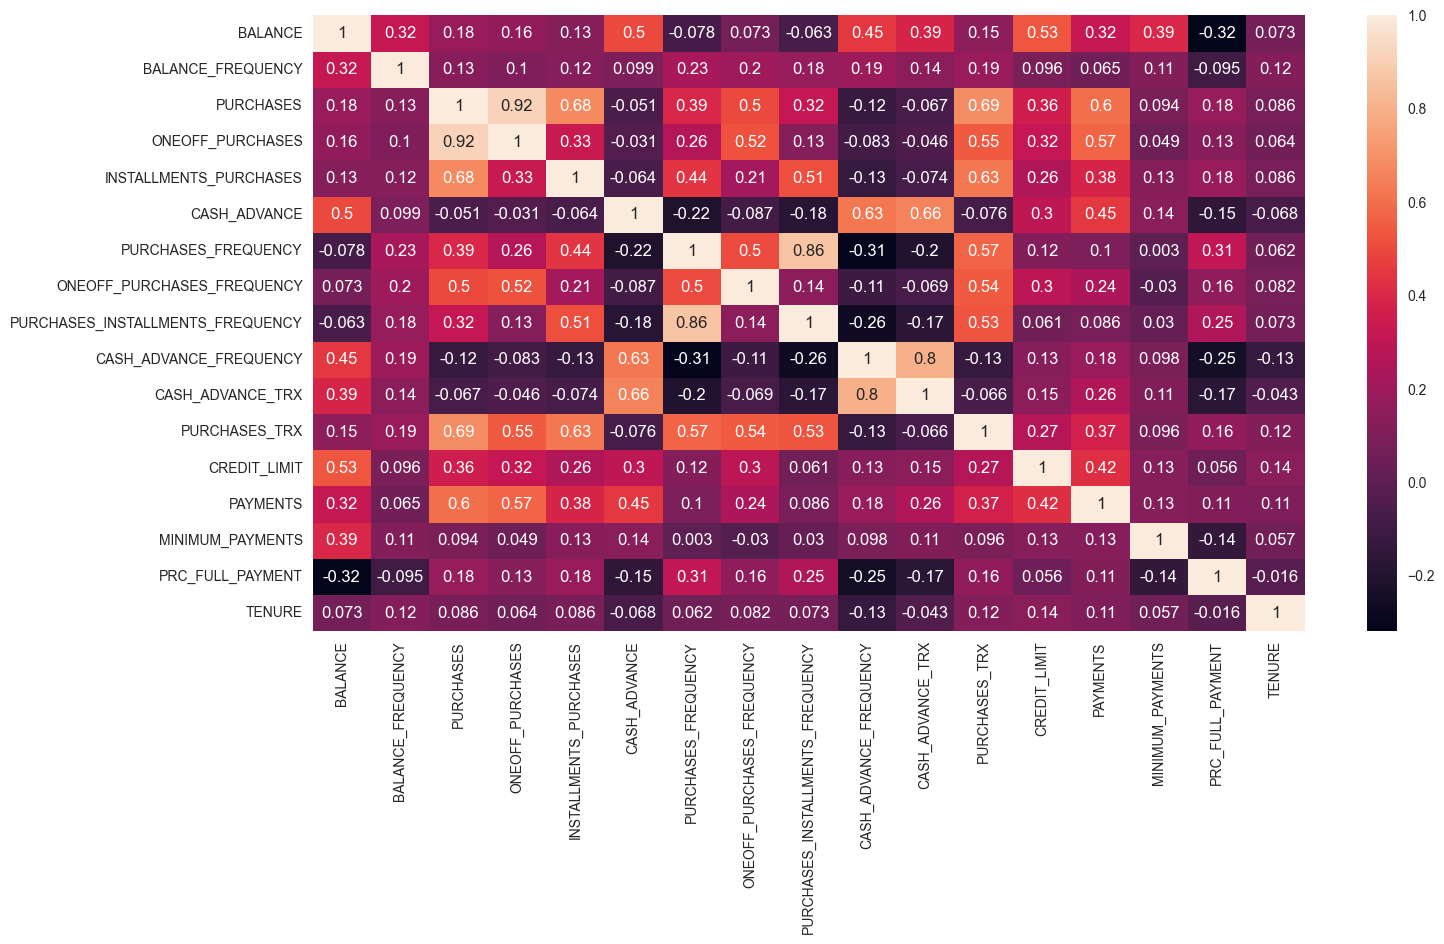

In [8]:
# Some features are highly correlated to other features.

plt.figure(figsize=(16,8))
sns.heatmap(df.corr(),annot=True)

In [9]:
# I'm creating a PCA object with n_components=0.9, which means we will keep enough 
# principal components to explain at least 90% of the variance in data.
# Alternatively, we could plot the cumulative explained variance ratio to choose
# the best value of n_components.

pca = PCA(n_components=0.9)
df_pca = pd.DataFrame(pca.fit_transform(df_scaled))

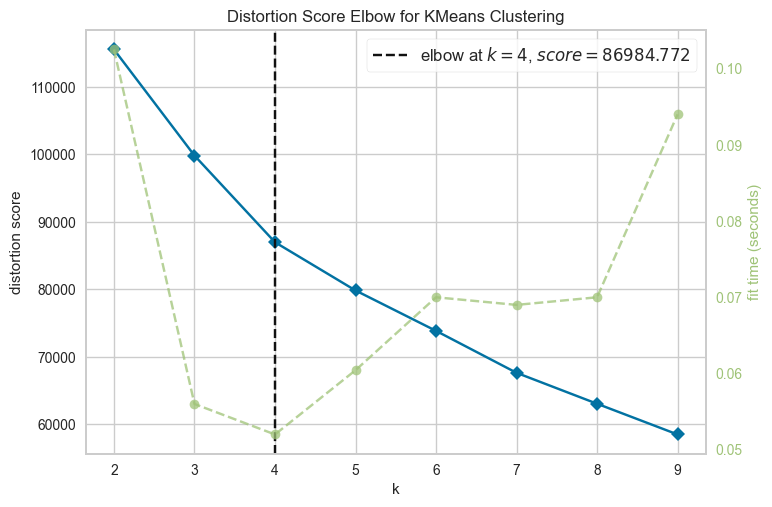

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [10]:
# By using the elbow method, we choose the optimal number of clusters.

elbow = KElbowVisualizer(KMeans(), k=(2, 10))
elbow.fit(df_pca)
elbow.show()

In [11]:
# Clustering with Kmeans algorithm. We are evaulating the model using silhouette score.
# 0.2 isn't a good score. We will try other algorithms as well.

kmeans = KMeans(n_clusters=4).fit(df_pca)

silhouette_score(df_pca, kmeans.labels_)

0.21696932438329916

In [12]:
# Here are the columns of our dataset sorted by correlation with principal components
# As you can see PRC_FULL_PAYMENTS variable is the most important in explaining the
# variation in the data.
# PRC_FULL_PAYMENTS is the percent of the full payment paid by the user.
# Cluster 0 has the lowest value for PRC_FULL_PAYMENTS, and cluster 3 has the highest.

print(pd.DataFrame(pca.components_,columns=df.columns).abs().sum(axis=0).sort_values(ascending=False))

PRC_FULL_PAYMENT                    2.722711
MINIMUM_PAYMENTS                    2.598651
BALANCE_FREQUENCY                   2.407274
CREDIT_LIMIT                        2.285764
TENURE                              2.139631
INSTALLMENTS_PURCHASES              2.055290
PAYMENTS                            2.031982
ONEOFF_PURCHASES_FREQUENCY          1.915168
PURCHASES_INSTALLMENTS_FREQUENCY    1.893616
PURCHASES_FREQUENCY                 1.868151
CASH_ADVANCE_TRX                    1.829888
CASH_ADVANCE_FREQUENCY              1.669017
ONEOFF_PURCHASES                    1.661167
BALANCE                             1.619118
CASH_ADVANCE                        1.469652
PURCHASES                           1.336678
PURCHASES_TRX                       1.290477
dtype: float64


In [13]:
# Now we can see clusters for each row.

df_kmeans = df.copy()
df_kmeans['clusters'] = kmeans.labels_

df_kmeans.head(20)

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,clusters
0,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,2
1,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,0
2,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,1
3,1666.670542,0.636364,1499.00,1499.00,0.00,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,864.206542,0.000000,12,2
4,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,2
5,1809.828751,1.000000,1333.28,0.00,1333.28,0.000000,0.666667,0.000000,0.583333,0.000000,0,8,1800.0,1400.057770,2407.246035,0.000000,12,1
6,627.260806,1.000000,7091.01,6402.63,688.38,0.000000,1.000000,1.000000,1.000000,0.000000,0,64,13500.0,6354.314328,198.065894,1.000000,12,3
7,1823.652743,1.000000,436.20,0.00,436.20,0.000000,1.000000,0.000000,1.000000,0.000000,0,12,2300.0,679.065082,532.033990,0.000000,12,1
8,1014.926473,1.000000,861.49,661.49,200.00,0.000000,0.333333,0.083333,0.250000,0.000000,0,5,7000.0,688.278568,311.963409,0.000000,12,2
9,152.225975,0.545455,1281.60,1281.60,0.00,0.000000,0.166667,0.166667,0.000000,0.000000,0,3,11000.0,1164.770591,100.302262,0.000000,12,2


<Axes: xlabel='CREDIT_LIMIT', ylabel='PURCHASES_TRX'>

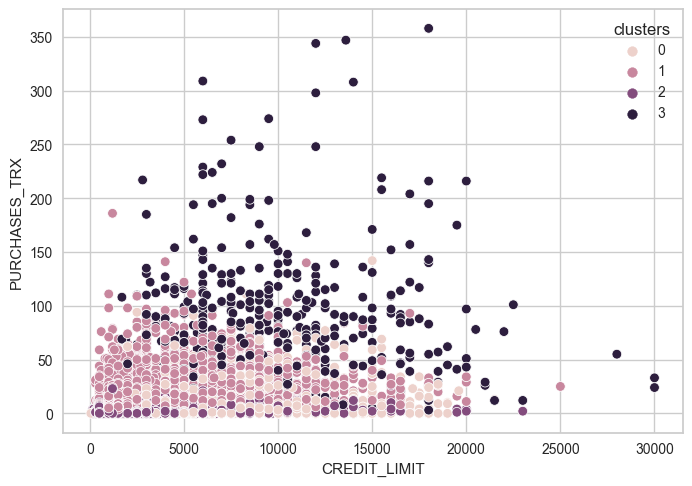

In [14]:
# Cluster 1 has made the most transactions.

sns.scatterplot(x=df_kmeans['CREDIT_LIMIT'],y=df_kmeans['PURCHASES_TRX'],hue=df_kmeans['clusters'])

<Axes: xlabel='CREDIT_LIMIT', ylabel='PURCHASES'>

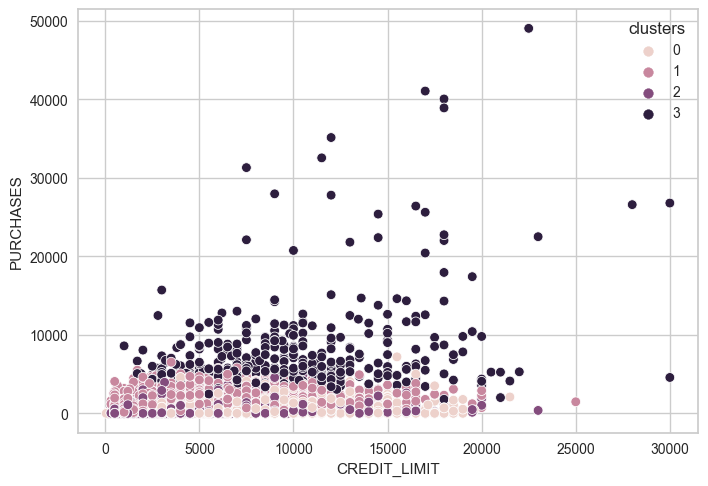

In [15]:
sns.scatterplot(x=df_kmeans['CREDIT_LIMIT'],y=df_kmeans['PURCHASES'],hue=df_kmeans['clusters'])

<Axes: xlabel='BALANCE', ylabel='ONEOFF_PURCHASES'>

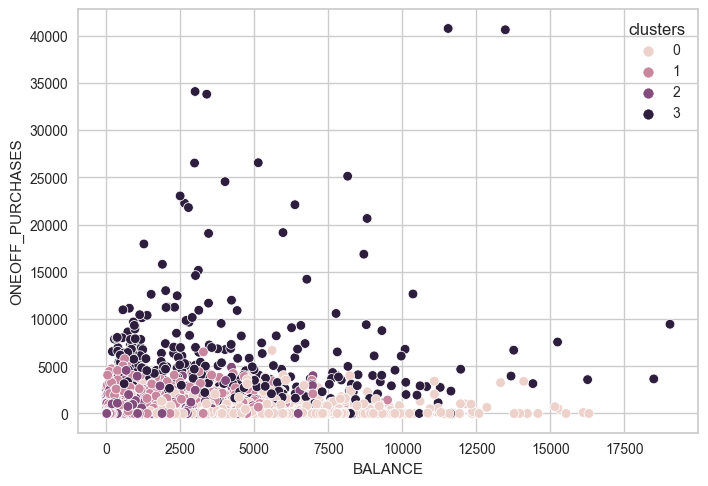

In [16]:
sns.scatterplot(x=df_kmeans['BALANCE'],y=df_kmeans['ONEOFF_PURCHASES'],hue=df_kmeans['clusters'])

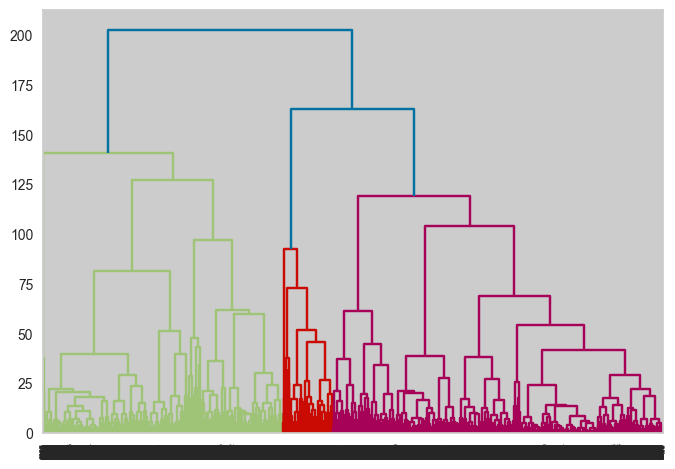

In [17]:
# Visualising the dentrogram to find out how many clusters we should use for hierarchical clustering.

shc.dendrogram((shc.linkage(df_pca, method ='ward')))
plt.show()

In [18]:
# Clustering with hierarchical clustering algorithm

hierarchical = AgglomerativeClustering(n_clusters=3).fit(df_pca)
silhouette_score(df_pca, hierarchical.labels_)

0.20297230449604647

In [19]:
df_hier = df.copy()
df_hier['clusters'] = hierarchical.labels_

<Axes: xlabel='CREDIT_LIMIT', ylabel='BALANCE'>

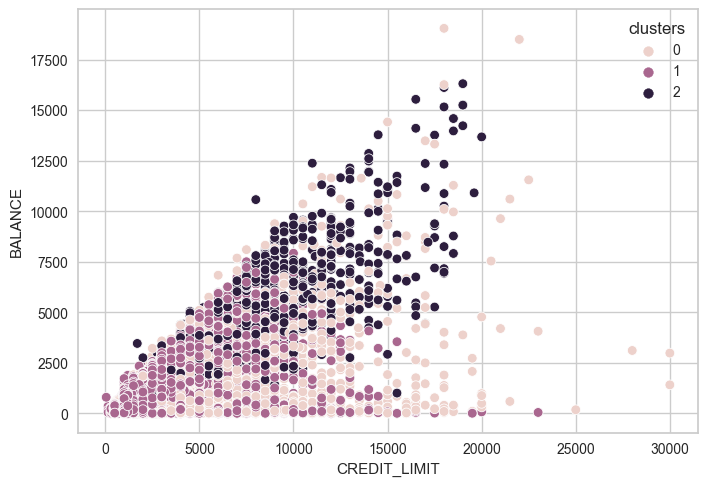

In [20]:
# In average, cluster 2 has comparably higher balance than the other two.

sns.scatterplot(x=df_hier['CREDIT_LIMIT'],y=df_hier['BALANCE'],hue=df_hier['clusters'])

<Axes: xlabel='CREDIT_LIMIT', ylabel='PURCHASES'>

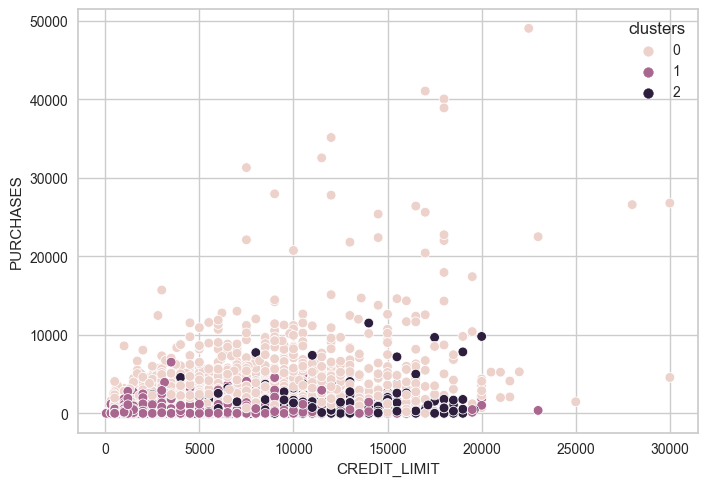

In [21]:
# As customers in cluster 0 make the most amount of purhcases, they become a target for marketing.

sns.scatterplot(x=df_hier['CREDIT_LIMIT'],y=df_hier['PURCHASES'],hue=df_hier['clusters'])

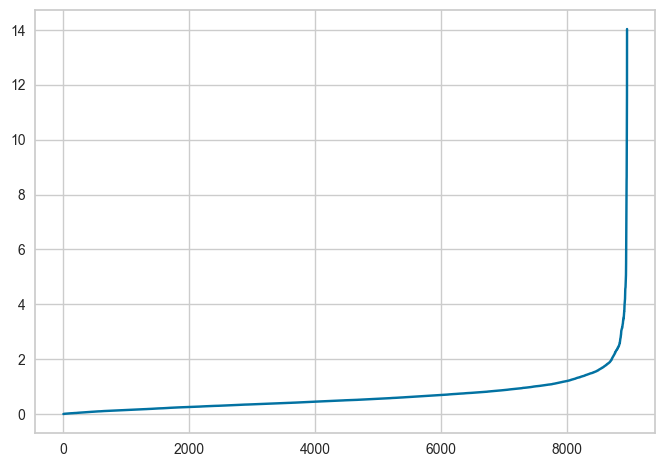

In [22]:
# Using the nearestNeighbors to calculate the average distance between each point and it's number of neighbors.

neighbors = NearestNeighbors(n_neighbors = 2).fit(df_pca)
distances, _ = neighbors.kneighbors(df_pca)

# The next line will extract the second nearest neighbors from the 'distances' array.
# We don't extract the first nearest neighbors because the distances to the first nearest 
# neighbors will be zero for each data point, as each point is its own nearest neighbor. 

distances = distances[:,1]
distances = np.sort(distances,axis=0)
plt.plot(distances)

In [23]:
# KneeLocator tool finds the y value for the elbow of the line in this chart. 
# That value of y will be our epsilon, which is a DBSCAN parameter.

kl = KneeLocator(range(len(distances)), distances, curve='convex',direction='increasing')
epsilon = distances[kl.elbow]
epsilon

3.478701699263945

In [24]:
# Clustering with DBSCAN
# This algorithm performed much better than the other two.

dbscan = DBSCAN(eps=epsilon,min_samples=10).fit(df_pca)
silhouette_score(df_pca, dbscan.labels_)

0.7054611995806088

In [25]:
df_dbscan = df.copy()
df_dbscan['clusters'] = dbscan.labels_

<Axes: xlabel='CREDIT_LIMIT', ylabel='PURCHASES'>

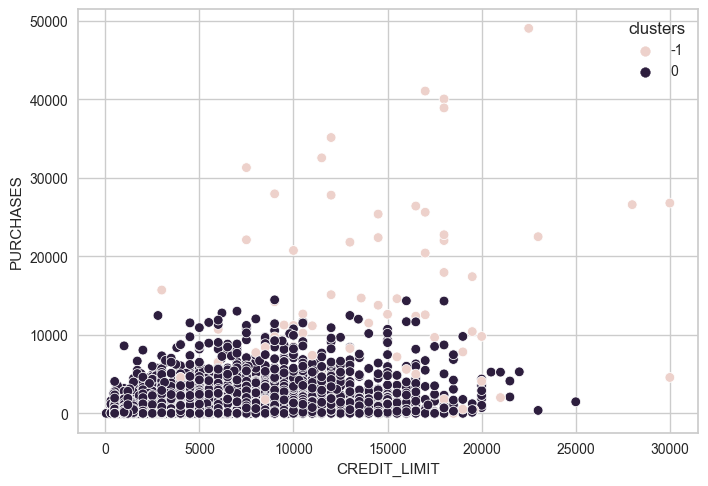

In [26]:
# DBSCAN got higher score, but created a single cluster(cluster 0).
# Data points in cluster -1 are outliers.

sns.scatterplot(x=df_dbscan['CREDIT_LIMIT'],y=df_dbscan['PURCHASES'],hue=df_dbscan['clusters'])